<a href="https://colab.research.google.com/github/MaCroDmT/Automation_Engineering/blob/main/Beta_Release_Work_Activity_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving workfolio-break-time-summary-06-Aug.xlsx to workfolio-break-time-summary-06-Aug.xlsx
📋 Summary Table:


Employee,Activity Type,Count



📊 Average Table:


Metric,'Session' time (minutes)
Average Idle Time,6.030000


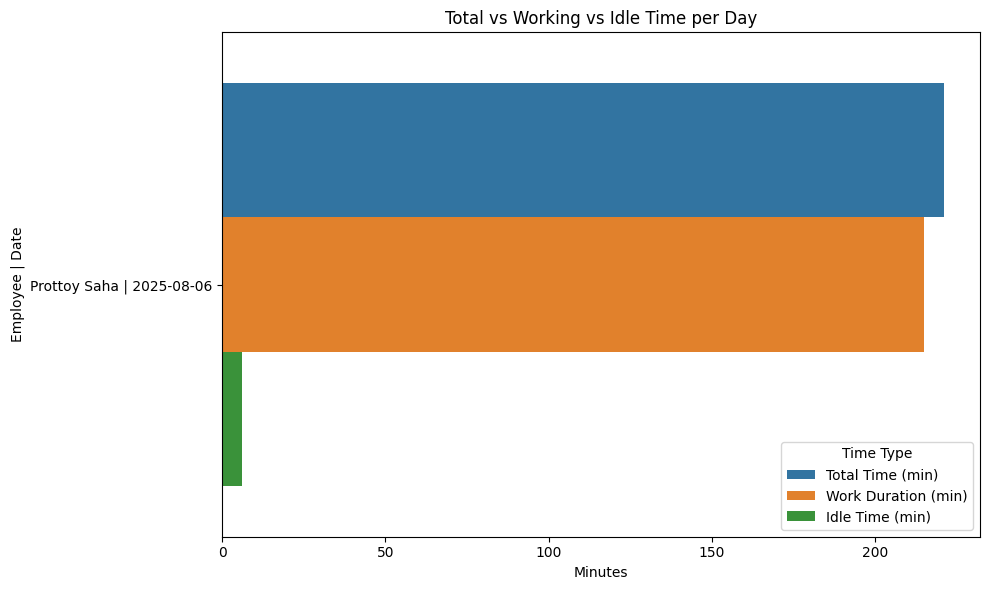

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.2 MB/s eta 0:00:00
✅ Excel file saved as time_summary_Prottoy_Saha_2025-08-06.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔹 Step 0: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from IPython.display import display
import plotly.express as px
from google.colab import files
import io

# 🔹 Step 1: Upload and Load Excel File
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[filename]))

# 🔹 Step 2: Preprocessing and Feature Engineering
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Classify activity types
def classify_activity(text):
    if isinstance(text, str):
        if "Worked for" in text:
            return "Worked"
        elif "Internet interrupted" in text:
            return "Internet Interrupted"
        elif "System suspended" in text:
            return "System Suspended"
    return "Other"

df['Activity Type'] = df['Activity Duration'].apply(classify_activity)

# Extract work duration in minutes
def extract_minutes(text):
    if isinstance(text, str) and "Worked for" in text:
        match = re.search(r"(\d+)h\s*(\d+)m\s*(\d+)s", text)
        if match:
            h = int(match.group(1))
            m = int(match.group(2))
            s = int(match.group(3))
            return round(h * 60 + m + s / 60, 2)
    return None

df['Duration (min)'] = df['Activity Duration'].apply(extract_minutes)
df_clean = df.dropna(subset=['Duration (min)'])

# 🔹 Step 3: Summary Table (excluding 'Worked' and 'Other')
full_summary_table = df.groupby(['Employee', 'Activity Type']).size().reset_index(name='Count')
summary_table_display = full_summary_table[
    ~full_summary_table['Activity Type'].isin(['Worked', 'Other'])
]

# 🔹 Step 4: Display Summary Table (Styled)
print("📋 Summary Table:")
styled_summary = (
    summary_table_display
    .style
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold'), ('border', '1px solid #ccc'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('background-color', '#f2f2f2'), ('color', '#111111'), ('border', '1px solid #ddd'), ('text-align', 'center')]}
    ])
    .set_properties(**{'text-align': 'center', 'color': '#111111', 'background-color': '#f2f2f2'})
    .hide(axis='index')
)
display(styled_summary)

# 🔹 Step 5: Time Parsing for Start and End Time
def parse_datetime(row, time_col):
    try:
        return datetime.strptime(f"{row['Date'].date()} {row[time_col]}", "%Y-%m-%d %I:%M %p")
    except:
        return pd.NaT

df['Start Datetime'] = df.apply(lambda row: parse_datetime(row, 'Start Time'), axis=1)
df['End Datetime'] = df.apply(lambda row: parse_datetime(row, 'End Time'), axis=1)

# Work duration again for idle time calc
def extract_minutes_safe(text):
    if isinstance(text, str) and "Worked for" in text:
        match = re.search(r"(\d+)h\s*(\d+)m\s*(\d+)s", text)
        if match:
            h = int(match.group(1))
            m = int(match.group(2))
            s = int(match.group(3))
            return round(h * 60 + m + s / 60, 2)
    return 0

df['Work Duration (min)'] = df['Activity Duration'].apply(extract_minutes_safe)

# 🔹 Step 6: Create `summary` DataFrame
summary = df.groupby(['Employee', 'Date']).agg({
    'Start Datetime': 'min',
    'End Datetime': 'max',
    'Work Duration (min)': 'sum'
}).reset_index()

summary['Total Time (min)'] = (summary['End Datetime'] - summary['Start Datetime']).dt.total_seconds() / 60
summary['Idle Time (min)'] = summary['Total Time (min)'] - summary['Work Duration (min)']

# 🔹 Step 7: Calculate and Show Average Idle Time
total_idle_time = summary['Idle Time (min)'].sum()
worked_count = df_clean.shape[0]
average_downtime = round(total_idle_time / worked_count, 2) if worked_count > 0 else 0

average_df = pd.DataFrame({
    "Metric": ["Average Idle Time"],
    "'Session' time (minutes)": [average_downtime]
})

print("\n📊 Average Table:")
styled_average = (
    average_df
    .style
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold'), ('border', '1px solid #ccc'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('background-color', '#f2f2f2'), ('color', '#111111'), ('border', '1px solid #ddd'), ('text-align', 'center')]}
    ])
    .set_properties(**{'text-align': 'center', 'color': '#111111', 'background-color': '#f2f2f2'})
    .hide(axis='index')
)
display(styled_average)

# 🔹 Step 8: Horizontal Bar Chart (Work, Idle, Total)
summary['Label'] = summary['Employee'].astype(str) + ' | ' + summary['Date'].dt.strftime('%Y-%m-%d')
melted = pd.melt(summary,
                 id_vars=['Label'],
                 value_vars=['Total Time (min)', 'Work Duration (min)', 'Idle Time (min)'],
                 var_name='Time Type',
                 value_name='Minutes')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, y='Label', x='Minutes', hue='Time Type')
plt.title("Total vs Working vs Idle Time per Day")
plt.xlabel("Minutes")
plt.ylabel("Employee | Date")
plt.tight_layout()
plt.show()

# 🔹 Step 9: Activity Type Pie Chart
activity_counts = df['Activity Type'].value_counts().reset_index()
activity_counts.columns = ['Activity Type', 'Count']

fig = px.pie(activity_counts,
             names='Activity Type',
             values='Count',
             title='🔍 Activity Type Distribution (All Employees)',
             hole=0.3)
fig.update_traces(textinfo='percent+label', hoverinfo='label+percent+value')
fig.show()






#Downloadable part


# 1. Install required package
!pip install -q xlsxwriter

# 2. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display
from google.colab import files
import io

# 3. Upload Excel file
#uploaded = files.upload()

# 4. Read Excel file
filename = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[filename]))

# 5. Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

def classify_activity(text):
    if isinstance(text, str):
        if "Worked for" in text:
            return "Worked"
        elif "Internet interrupted" in text:
            return "Internet Interrupted"
        elif "System suspended" in text:
            return "System Suspended"
    return "Other"

df['Activity Type'] = df['Activity Duration'].apply(classify_activity)

def extract_minutes(text):
    if isinstance(text, str) and "Worked for" in text:
        match = re.search(r"(\d+)h\s*(\d+)m\s*(\d+)s", text)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2))
            seconds = int(match.group(3))
            return round(hours * 60 + minutes + seconds / 60, 2)
    return None

df['Duration (min)'] = df['Activity Duration'].apply(extract_minutes)
df_clean = df.dropna(subset=['Duration (min)'])

# Summary Table (exclude 'Worked' and 'Other')
full_summary_table = df.groupby(['Employee', 'Activity Type']).size().reset_index(name='Count')
summary_table_display = full_summary_table[
    ~full_summary_table['Activity Type'].isin(['Worked', 'Other'])
]

# Calculate average idle time
# First parse Start/End datetime from columns 'Start Time' and 'End Time'

from datetime import datetime

def parse_datetime(row, time_col):
    try:
        return datetime.strptime(f"{row['Date'].date()} {row[time_col]}", "%Y-%m-%d %I:%M %p")
    except:
        return pd.NaT

df['Start Datetime'] = df.apply(lambda row: parse_datetime(row, 'Start Time'), axis=1)
df['End Datetime'] = df.apply(lambda row: parse_datetime(row, 'End Time'), axis=1)

df['Work Duration (min)'] = df['Activity Duration'].apply(extract_minutes)

summary = df.groupby(['Employee', 'Date']).agg({
    'Start Datetime': 'min',
    'End Datetime': 'max',
    'Work Duration (min)': 'sum'
}).reset_index()

summary['Total Time (min)'] = (summary['End Datetime'] - summary['Start Datetime']).dt.total_seconds() / 60
summary['Idle Time (min)'] = summary['Total Time (min)'] - summary['Work Duration (min)']

# Average idle time per worked session
total_idle_time = summary['Idle Time (min)'].sum()
worked_count = df_clean.shape[0]
average_downtime = round(total_idle_time / worked_count, 2) if worked_count > 0 else 0

average_df = pd.DataFrame({
    "Metric": ["Average Idle Time"],
    "'Session' time (minutes)": [average_downtime]
})

# Prepare data for bar chart
summary['Label'] = summary['Employee'].astype(str) + ' | ' + summary['Date'].dt.strftime('%Y-%m-%d')
melted = pd.melt(summary,
                 id_vars=['Label'],
                 value_vars=['Total Time (min)', 'Work Duration (min)', 'Idle Time (min)'],
                 var_name='Time Type',
                 value_name='Minutes')

# Save bar chart as PNG
bar_path = '/content/bar_chart.png'
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, y='Label', x='Minutes', hue='Time Type')
plt.title("Total vs Working vs Idle Time per Day")
plt.xlabel("Minutes")
plt.ylabel("Employee | Date")
plt.tight_layout()
plt.savefig(bar_path, dpi=150)
plt.close()

# Create pie chart using Matplotlib (replace Plotly pie chart)
activity_counts = df['Activity Type'].value_counts().reset_index()
activity_counts.columns = ['Activity Type', 'Count']

pie_path = '/content/pie_chart.png'
plt.figure(figsize=(6,6))
plt.pie(activity_counts['Count'], labels=activity_counts['Activity Type'], autopct='%1.1f%%', startangle=140)
plt.title("Activity Type Distribution (All Employees)")
plt.axis('equal')  # Equal aspect ratio for circle
plt.savefig(pie_path, dpi=150)
plt.close()

# === Export to Excel ===
import xlsxwriter

# Dynamic filename based on first employee and date
first_emp = df['Employee'].dropna().astype(str).iloc[0].replace(" ", "_")
first_date = df['Date'].dropna().dt.strftime('%Y-%m-%d').iloc[0]
filename = f"time_summary_{first_emp}_{first_date}.xlsx"

output_path = f"/content/{filename}"
writer = pd.ExcelWriter(output_path, engine='xlsxwriter')
workbook = writer.book

# Write summary table
summary_sheet = 'Activity Summary'
summary_table_display.to_excel(writer, sheet_name=summary_sheet, index=False, startrow=1)
worksheet1 = writer.sheets[summary_sheet]
header_format = workbook.add_format({'bold': True, 'bg_color': '#1f77b4', 'color': 'white', 'border': 1, 'align': 'center'})
cell_format = workbook.add_format({'bg_color': '#f2f2f2', 'color': '#111111', 'border': 1, 'align': 'center'})

for col_num, value in enumerate(summary_table_display.columns.values):
    worksheet1.write(0, col_num, value, header_format)
for row in range(summary_table_display.shape[0]):
    for col in range(summary_table_display.shape[1]):
        worksheet1.write(row+1, col, summary_table_display.iat[row, col], cell_format)

# Write average table
avg_sheet = "Avg Idle Time"
average_df.to_excel(writer, sheet_name=avg_sheet, index=False, startrow=1)
worksheet2 = writer.sheets[avg_sheet]
for col_num, value in enumerate(average_df.columns.values):
    worksheet2.write(0, col_num, value, header_format)
for row in range(average_df.shape[0]):
    for col in range(average_df.shape[1]):
        worksheet2.write(row+1, col, average_df.iat[row, col], cell_format)

# Add charts sheet and insert images
chart_sheet = "Charts"
worksheet3 = workbook.add_worksheet(chart_sheet)
worksheet3.insert_image('B2', bar_path, {'x_scale': 0.7, 'y_scale': 0.7})
worksheet3.insert_image('B25', pie_path, {'x_scale': 0.7, 'y_scale': 0.7})

writer.close()

print(f"✅ Excel file saved as {filename}")

# Download file in Colab
files.download(output_path)
